In [26]:
from datetime import date

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import rasterio as rio
from contextily import add_basemap
from pystac_client import Client
from rasterio import transform, windows
from rasterio.enums import Resampling
from rasterio.features import rasterize
from rasterio.warp import reproject
from skimage.exposure import rescale_intensity

In [48]:
# Date
temporal = ("2024-01-01", "2024-12-31")

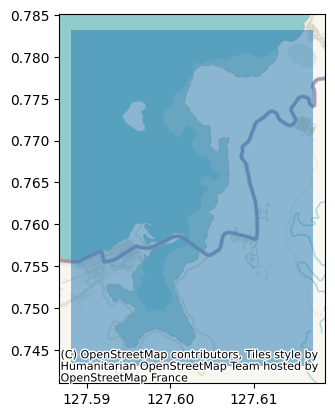

In [6]:
roi = gpd.read_file("../data/Boundary_Mng/Boundary_Mng.shp")
ax = roi.plot(alpha=0.5)
add_basemap(ax=ax, crs="EPSG:4326")

In [7]:
# Create a image mask for image shape (height and width)
# Defined images optimal shape in 30 meter
# 1 degree = 111.000 meter
bounds = tuple(roi.total_bounds)
width = int(abs(bounds[0] - bounds[2]) * 111_000 / 10)
height = int(abs(bounds[1] - bounds[3]) * 111_000 / 10)
shape = (height, width)
print(f"Optimal Shapes: {shape}")

Optimal Shapes: (445, 320)


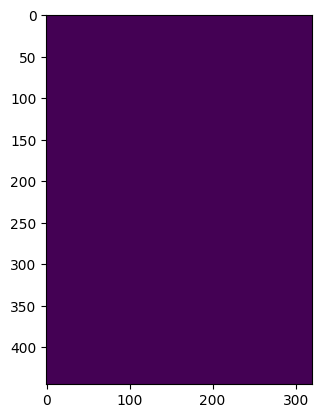

In [8]:
# Create raster of the ROI
transform_roi = transform.from_bounds(*bounds, height=shape[0], width=shape[1])
raster_roi = rasterize(
    [(geometry, 1) for geometry in roi.geometry],
    out_shape=shape,
    fill=0,
    nodata=0,
    transform=transform.from_bounds(*bounds, height=shape[0], width=shape[1]),
    default_value=0,
)
plt.imshow(raster_roi)

In [9]:
# Client to search data
client = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
# Search Sentinel-2 data
s2_col = client.search(
    collections=["sentinel-2-l2a"],
    bbox=bounds,
    datetime=temporal,
    query={"eo:cloud_cover": {"lte": 25}},
).item_collection()
s2_col

In [75]:
# Collect all data

# Bands S2
s2_bands = [
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B09",
    "B11",
    "B12",
]

# Stacks
s2_stacks = np.empty((len(s2_col), len(s2_bands), *shape), dtype="int16")

# Loop all the collection
for x in range(len(s2_col)):
    item = s2_col[x]
    id = item.id
    print(f"Proceesing {id} ({x + 1} / {len(s2_col)})")
    assets = item.assets

    # Date
    date_data = date.fromisoformat(item.properties["datetime"].split("T")[0])
    cutoff = date.fromisoformat("2022-01-25")

    # SCL band for cloud masking
    with rio.open(assets["SCL"].href) as source:
        bounds_crs = tuple(roi.to_crs(source.crs).total_bounds)
        window = windows.from_bounds(*bounds_crs, transform=source.transform)
        transform_window = windows.transform(window, source.transform)
        scl = source.read(1, boundless=True, window=window, fill_value=source.nodata)

        # Reproject scl
        scl, new_transform = reproject(
            scl,
            np.empty(shape, dtype=scl.dtype),
            src_transform=transform_window,
            src_crs=source.crs,
            src_nodata=source.nodata,
            dst_transform=transform_roi,
            dst_crs="EPSG:4326",
            dst_nodata=source.nodata,
            resampling=Resampling.nearest,
        )

        cloud_mask = ((scl >= 1) & (scl <= 3)) | ((scl >= 7) & (scl <= 10))

        del scl

    # Images per bands S2
    for b in range(len(s2_bands)):
        band = s2_bands[b]

        print(f"Proceesing {band}")

        with rio.open(assets[band].href) as source:
            window = windows.from_bounds(*bounds_crs, transform=source.transform)
            transform_window = windows.transform(window, source.transform)

            # Read image
            image = source.read(
                1,
                boundless=True,
                window=window,
                fill_value=source.nodata,
            )

            # Reproject image
            image, new_transform = reproject(
                image,
                np.empty(shape, dtype=image.dtype),
                src_transform=transform_window,
                src_crs=source.crs,
                src_nodata=source.nodata,
                dst_transform=transform_roi,
                dst_crs="EPSG:4326",
                dst_nodata=source.nodata,
                resampling=Resampling.nearest,
            )

            # Mask image
            image = np.ma.array(
                image,
                mask=(image == source.nodata) | cloud_mask | (raster_roi == 0),
                dtype="int16",
            )

            # Cutoff 1000
            if date_data > cutoff:
                image = image - 1000
                image[image < 0] = 0

            s2_stacks[x, b] = image.astype("int16")

    del cloud_mask

s2_stacks

Proceesing S2A_MSIL2A_20241210T015401_R117_T52NCF_20241210T040250 (1 / 9)
Proceesing B01
Proceesing B02
Proceesing B03
Proceesing B04
Proceesing B05
Proceesing B06
Proceesing B07
Proceesing B08
Proceesing B8A
Proceesing B09
Proceesing B11
Proceesing B12
Proceesing S2B_MSIL2A_20241026T015409_R117_T52NCF_20241026T034152 (2 / 9)
Proceesing B01
Proceesing B02
Proceesing B03
Proceesing B04
Proceesing B05
Proceesing B06
Proceesing B07
Proceesing B08
Proceesing B8A
Proceesing B09
Proceesing B11
Proceesing B12
Proceesing S2B_MSIL2A_20240926T015359_R117_T52NCF_20240926T034203 (3 / 9)
Proceesing B01
Proceesing B02
Proceesing B03
Proceesing B04
Proceesing B05
Proceesing B06
Proceesing B07
Proceesing B08
Proceesing B8A
Proceesing B09
Proceesing B11
Proceesing B12
Proceesing S2B_MSIL2A_20240529T015619_R117_T52NCF_20240529T064316 (4 / 9)
Proceesing B01
Proceesing B02
Proceesing B03
Proceesing B04
Proceesing B05
Proceesing B06
Proceesing B07
Proceesing B08
Proceesing B8A
Proceesing B09
Proceesing B11

array([[[[ 1280,  1280,  1280, ...,  1416,  1416,  1416],
         [ 1280,  1280,  1280, ...,  1416,  1416,  1416],
         [ 1280,  1280,  1280, ...,  1416,  1416,  1416],
         ...,
         [  283,   283,   283, ...,  1396,  1396,  1396],
         [  283,   283,   283, ...,  1396,  1396,  1396],
         [  283,   283,   283, ...,  1396,  1396,  1396]],

        [[ 1212,  1222,  1216, ...,  1392,  1475,  1516],
         [ 1237,  1229,  1220, ...,  1540,  1574,  1556],
         [ 1220,  1210,  1204, ...,  1646,  1770,  1742],
         ...,
         [  247,   213,   208, ...,  1376,  1371,  1376],
         [  248,   219,   240, ...,  1342,  1366,  1379],
         [  223,   233,   183, ...,  1379,  1394,  1384]],

        [[ 1158,  1161,  1148, ...,  1520,  1562,  1642],
         [ 1170,  1140,  1148, ...,  1614,  1716,  1656],
         [ 1158,  1155,  1148, ...,  1734,  1846,  1674],
         ...,
         [  480,   439,   482, ...,  1612,  1628,  1605],
         [  472,   482,   

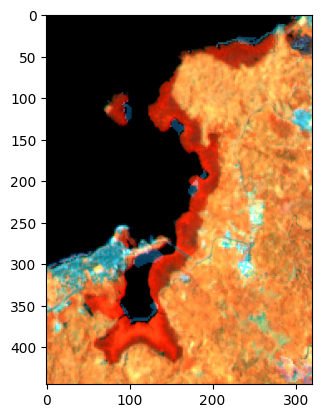

In [ ]:
# Aggregate Sentinel-2 data
s2_image = np.ma.empty((len(s2_bands), *shape), dtype="int16")
for x in range(len(s2_bands)):
    band_median = np.ma.median(s2_stacks[:, x, :, :], 0).astype("int16")
    s2_image[x] = band_median

# Visualize it
composite_s2 = np.dstack(
    [
        rescale_intensity(s2_image[7] / 1e4, in_range=(0.1, 0.4), out_range=(0, 1)),
        rescale_intensity(s2_image[10] / 1e4, in_range=(0.05, 0.3), out_range=(0, 1)),
        rescale_intensity(s2_image[11] / 1e4, in_range=(0.025, 0.25), out_range=(0, 1)),
    ]
)

plt.imshow(composite_s2)

In [77]:
s2_output = np.nan_to_num(s2_image, nan=-9999)
with rio.open(
    "s2_2024.tif",
    "w",
    "COG",
    count=s2_output.shape[0],
    width=s2_output.shape[2],
    height=s2_output.shape[1],
    crs="EPSG:4326",
    transform=transform_roi,
    nodata=-9999,
    dtype="int16",
    resampling=Resampling.bilinear,
    compress="zstd",
) as source:
    source.write(s2_output)
    source.descriptions = s2_bands

In [79]:
# Search Sentinel-1 data
s1_col = client.search(
    collections=["sentinel-1-rtc"], bbox=bounds, datetime=temporal
).item_collection()

s1_col

In [81]:
# Bands S1
s1_bands = ["vv", "vh"]

# Sentinel-1
s1_stacks = np.ma.empty((len(s1_col), len(s1_bands), *shape), dtype="int16")

for x in range(len(s1_col)):
    try:
        data = s1_col[x]
        id = data.id
        print(f"Processing {id} ({x + 1} / {len(s1_col)})")

        for b in range(len(s1_bands)):
            band = s1_bands[b]
            print(f"Processing band {band} {id}")
            with rio.open(data.assets[band].href) as source:
                # Reproject ROI
                roi_reproject = roi.to_crs(source.crs)
                bounds_reproject = tuple(roi_reproject.total_bounds)

                # Create a window to read a chunk of the S1
                window = windows.from_bounds(
                    *bounds_reproject, transform=source.transform
                )
                transform_window = windows.transform(window, source.transform)

                # Read the S1 using the window
                image = source.read(
                    1,
                    window=window,
                    boundless=True,
                    fill_value=source.nodata,
                )

                # Reproject mask
                image, new_transform = reproject(
                    image,
                    np.empty(shape, dtype=image.dtype),
                    src_transform=transform_window,
                    src_crs=source.crs,
                    src_nodata=source.nodata,
                    dst_transform=transform_roi,
                    dst_crs="EPSG:4326",
                    dst_nodata=source.nodata,
                    resampling=Resampling.bilinear,
                )

                # Mask the S1
                image = np.ma.array(
                    (image * 1e4),
                    mask=(image == source.nodata) | (raster_roi == 0),
                    dtype="int16",
                )

                # Put the DEM into collection
                s1_stacks[x, b] = image

    except Exception as e:
        print.info(f"Error {id}: {e}")
        continue

Processing S1A_IW_GRDH_1SDV_20241224T210954_20241224T211019_057139_070685_rtc (1 / 23)
Processing band vv S1A_IW_GRDH_1SDV_20241224T210954_20241224T211019_057139_070685_rtc
Processing band vh S1A_IW_GRDH_1SDV_20241224T210954_20241224T211019_057139_070685_rtc
Processing S1A_IW_GRDH_1SDV_20241212T210955_20241212T211020_056964_06FF7C_rtc (2 / 23)
Processing band vv S1A_IW_GRDH_1SDV_20241212T210955_20241212T211020_056964_06FF7C_rtc
Processing band vh S1A_IW_GRDH_1SDV_20241212T210955_20241212T211020_056964_06FF7C_rtc
Processing S1A_IW_GRDH_1SDV_20241118T210957_20241118T211022_056614_06F1AA_rtc (3 / 23)
Processing band vv S1A_IW_GRDH_1SDV_20241118T210957_20241118T211022_056614_06F1AA_rtc
Processing band vh S1A_IW_GRDH_1SDV_20241118T210957_20241118T211022_056614_06F1AA_rtc
Processing S1A_IW_GRDH_1SDV_20241025T210957_20241025T211022_056264_06E3BE_rtc (4 / 23)
Processing band vv S1A_IW_GRDH_1SDV_20241025T210957_20241025T211022_056264_06E3BE_rtc
Processing band vh S1A_IW_GRDH_1SDV_20241025T21095

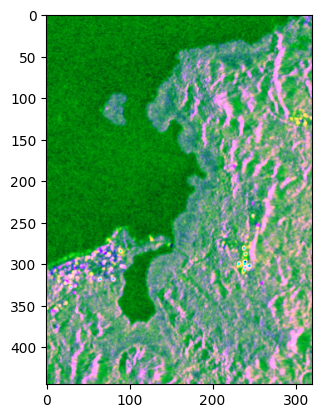

In [82]:
# Create a median composite
s1_image = np.ma.empty((len(s1_bands), *shape), dtype="int16")
for x in range(len(s1_bands)):
    band_median = np.ma.median(s1_stacks[:, x, :, :], 0).astype("int16")
    s1_image[x] = band_median

# Visualize
composite_s1 = np.dstack(
    [
        rescale_intensity(s1_image[0] / 1e4, in_range=(0.1, 0.4), out_range=(0, 1)),
        rescale_intensity(
            (s1_image[0] - s1_image[1]) / (s1_image[0] + s1_image[1]),
            in_range=(0, 1),
            out_range=(0, 1),
        ),
        rescale_intensity(s1_image[1] / 1e4, in_range=(0, 0.1), out_range=(0, 1)),
    ]
)
plt.imshow(composite_s1)

In [83]:
s1_output = np.nan_to_num(s1_image, nan=-9999)
with rio.open(
    "s1_2024.tif",
    "w",
    "COG",
    count=s1_output.shape[0],
    width=s1_output.shape[2],
    height=s1_output.shape[1],
    crs="EPSG:4326",
    transform=transform_roi,
    nodata=-9999,
    dtype="int16",
    resampling=Resampling.bilinear,
    compress="zstd",
) as source:
    source.write(s1_output)
    source.descriptions = s1_bands
